# PREVISÃO DO CONSUMO DE COMBUSTÍVEL DAS VIATURAS DA PMPE


**Instruções gerais**: 
1. Para começar é necessário carregar o arquivo no colab. Para fazer isso, seguir os passos do vídeo:
[Video Demonstrativo](https://drive.google.com/file/d/1oTL9Li6Yy1IxAixkEPnwtNNnfu0fOCxG/view?usp=sharing)

2. Existem alguns parâmetros no início do pré processamento: o caminho dos dados e o modelo do carro, que são explicados no vídeo.
Porém, na seção do SARIMA é necessário escolher os anos de início dos dados e o ano que se deseja obter a previsão
3. A previsão será possível de acordo com a disponibilidade dos dados anteriores.

# Pré processamento dos dados 

In [ ]:
#imports
import warnings
import itertools
import matplotlib
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'G'
import datetime

In [ ]:
#@title Path do arquivo
path = '/content/consumo_combustivel_18_19_20_anonimizado.csv'#@param { type: "string"}

#Importamos algumas bibliotecas que serão utilizadas.
import pandas as pd
import math
import matplotlib.pyplot as plt
import statistics
import numpy as np
from datetime import datetime

In [ ]:
#@title Filtros pro modelo SARIMA - modelo de carro


modelo= 'HILUX' #@param ["SPACEFOX", "HILUX", "SPIN", "S 10"]


In [ ]:
#@title Ano de Início dos Dados e Ano de Previsão
ano_comeco = '2018'#@param { type: "string"}
ano_previsao = '2020'#@param { type: "string"}

In [ ]:
#Le o csv do drive:

db = pd.read_csv(path, sep=';')

# Retirando acentos e caracteres especiais
!pip install unidecode
from unidecode import unidecode

def remover_acentos(item):
  aux = []
  for i in item:
    aux.append(unidecode(i))
  return aux

db.columns = remover_acentos(db.columns)

     |████████████████████████████████| 245kB 4.2MB/s 


In [ ]:
modelos_interesse = ["SPACEFOX", "HILUX", "SPIN", "S 10"]

for i in db['MODELO VEICULO']:
  for j in modelos_interesse:
    if j == 'S 10':
      if 'S10' in i and 'S10' != i:
        db['MODELO VEICULO'] = db['MODELO VEICULO'].str.replace(i, j)       
    if j.lower() in i.lower() and j.lower() != i.lower():
      db['MODELO VEICULO'] = db['MODELO VEICULO'].str.replace(i, j)

In [ ]:
#SELECIONA COLUNAS, LIMPAS DADOS VAZIOS E REMOVE ACENTO DO TIPO DE VEICULO
# db = db[ ['HODOMETRO', 'CONSUMO', 'DESLOCAMENTO', 'DATAHORA TRANS', 'VEICULO', 'QUANTIDADE', 'TIPO VEICULO', 'SERVICO'] ]
# db = db.dropna()
db['TIPO VEICULO'] = remover_acentos(db['TIPO VEICULO'])

In [ ]:
#Selecionando apenas os serviços/tipos de veículo escolhidos
# SERVIÇO (TIPOS): RETIRAR 'ARLA32', 'Borracharia', 'Troca de Óleo', 'Lubrificante', 'NOX'
db = db.query('`TIPO VEICULO` == "AUTOMOVEL" or `TIPO VEICULO` == "VEICULO" or `TIPO VEICULO` == "CAMINHONETE"')
db = db.query('SERVICO != "ARLA32" and SERVICO != "Borracharia" and SERVICO != "Troca de Oleo" and SERVICO != "Lubrificante" and SERVICO != "NOX"')
db['SERVICO'] = db['SERVICO'].str.replace('Diesel S10/S50', 'Diesel')
db['SERVICO'] = db['SERVICO'].str.replace('S10/S50', 'Diesel')

In [ ]:
# Função pra Tratamento especial pros dados de Data e Hora
#1. Tira a informação de hora, já que nem todas as entradas tem essa informação
#2. Padroniza para que todas as horas estejam no formato "%dd/%mm/%YYYY"
#3. Transforma em datetime pra trabalhar mais facilmente com esses dados :)

def handle_data(data_hora_trans):
  novo_data = data_hora_trans.str.replace('-', '/')
  lista_aux = []
  for i in novo_data:
    aux = i.split()[0]
    aux_2 = aux.split('/')
    if int(aux_2[0]) >= 2000:
      aux = aux_2[2] + '/' + aux_2[1] + '/' + aux_2[0] 
    elif int(aux_2[2]) < 2000:
      aux = aux_2[0] + '/' + aux_2[1] + '/' + '20' + aux_2[2]
    lista_aux.append(datetime.strptime(aux, '%d/%m/%Y'))
    novo_data = lista_aux
  return novo_data

In [ ]:
#Tratamento para as colunas numéricas: tira os pontos desnecessários e coloca pontos no lugar das vírgulas. 
#Tb faz cast pra float

db['CONSUMO'] = db['CONSUMO'].str.replace('.', '').str.replace(',', '.').astype('float64')
db['QUANTIDADE'] = db['QUANTIDADE'].str.replace('.', '').str.replace(',', '.').astype('float64')
db['DATAHORA TRANS'] = handle_data(db['DATAHORA TRANS'])

In [ ]:
"""
Recalculando as distâncias percorridas
com base na medida do hodometro e consequentemente recalculando os deslocamentos.
"""

def calculate_desloc():
  retorno = []
  carros = db['VEICULO'].unique()
  for i in range(0, len(carros)):
    car_id = str(carros[i])
    _query = 'VEICULO ==' + car_id 
    aux = db.query(_query).sort_values(by='HODOMETRO') 
    aux_hodo = aux['HODOMETRO']
    aux['DESLOCAMENTO'] = get_aux_desloc(aux_hodo)
    aux['CONSUMO'] = get_aux_consumo(aux['DESLOCAMENTO'], aux['QUANTIDADE'])
    if i == 0:
      retorno = aux
    else:
      retorno = retorno.append(aux)

  return retorno

def get_aux_desloc(aux_hodo):
  aux_desloc = []
  last = -1
  for j in aux_hodo:
    if last == -1:
      last = j
      aux_desloc.append(0)
    else:
      desloc = j - last
      aux_desloc.append(desloc)
      last = j
  return aux_desloc

def get_aux_consumo(aux_desloc, aux_qtd):
  aux_consumo = []
  aux_qtd = aux_qtd.array
  for index, j in enumerate(aux_desloc):
    consumo = j / aux_qtd[index]
    aux_consumo.append(consumo)
  return aux_consumo

db = calculate_desloc()


In [ ]:
#Retirar outliers de consumo baseado na variância
desc = db['CONSUMO'].describe()
novo_max = desc[1] + 3 * desc[2]
db = db[db['CONSUMO'] < novo_max]

# 1. selecioanando apenas o modelo de carro escolhido
q = '`MODELO VEICULO` == ' + '\'' + modelo + '\''
db = db.query(q)

In [ ]:
desc

count    583594.000000
mean          8.040383
std           5.056816
min           0.000000
25%           6.625578
50%           7.869565
75%           9.184926
max        1620.000000
Name: CONSUMO, dtype: float64

In [ ]:
db.sort_values(by='VEICULO')

,AUTORIZACAO,NOME FANTASIA,CIDADE,UF,SERVICO,HODOMETRO,DESLOCAMENTO,CONSUMO,QUANTIDADE,UNITARIO,VALOR,DATAHORA TRANS,VEICULO,ANO FABRICACAO,ANO MODELO,TIPO VEICULO,MARCA,MODELO VEICULO,CONDUTOR,CENTRO DE CUSTO,Unnamed: 20
251210,61927919,POSTO MODELO,GARANHUNS,PE,Diesel,157089.0,158.0,7.159039,22.07,"3,46","76,36",2019-04-03,21,2017,2017,CAMINHONETE,TOYOTA,HILUX,3047,3,NaN
58599,60694979,POSTO MODELO,GARANHUNS,PE,Diesel,133230.0,235.0,8.508327,27.62,"3,49","96,39",2018-12-28,21,2017,2017,CAMINHONETE,TOYOTA,HILUX,4536,3,NaN
57880,60680824,POSTO MODELO,GARANHUNS,PE,Diesel,132995.0,283.0,11.310951,25.02,"3,49","87,32",2018-12-27,21,2017,2017,CAMINHONETE,TOYOTA,HILUX,636,3,NaN
57183,60668173,POSTO MODELO,GARANHUNS,PE,Diesel,132712.0,273.0,9.650053,28.29,"3,49","98,73",2018-12-26,21,2017,2017,CAMINHONETE,TOYOTA,HILUX,2509,3,NaN
56616,60664456,POSTO MODELO,GARANHUNS,PE,Diesel,132439.0,354.0,9.888268,35.80,"3,49","124,94",2018-12-25,21,2017,2017,CAMINHONETE,TOYOTA,HILUX,1803,3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645173,65414187,POSTO LITORAL SUL,RIO FORMOSO,PE,Diesel,42711.0,251.0,7.223022,34.75,"3,30","114,64",2020-05-01,5037,2018,2018,CAMINHONETE,TOYOTA,HILUX,3381,47,NaN
648013,65439411,TAMANDARE COMBUSTIVE,TAMANDARE,PE,Diesel,43192.0,481.0,9.620000,50.00,"2,99","149,50",2020-05-06,5037,2018,2018,CAMINHONETE,TOYOTA,HILUX,2016,47,NaN
648232,65451005,POSTO PORTO DO SOL,BARREIROS,PE,Diesel,43414.0,222.0,5.692308,39.00,"3,00","116,97",2020-05-07,5037,2018,2018,CAMINHONETE,TOYOTA,HILUX,306,47,NaN
649272,65466013,POSTO PORTO DO SOL,BARREIROS,PE,Diesel,44138.0,319.0,8.092339,39.42,"3,00","118,22",2020-05-10,5037,2018,2018,CAMINHONETE,TOYOTA,HILUX,2418,47,NaN


In [ ]:
banana =  db[['CONSUMO', 'DATAHORA TRANS']]
banana = banana.rename(columns={'DATAHORA TRANS': 'DATA'})

In [ ]:
#Pré processamento pra funcionar o SARIMA :-) (index = datetime)
maca = banana.sort_values(by='DATA')
maca = maca[['CONSUMO', 'DATA']]
maca['DATA'] = pd.to_datetime(maca['DATA'])
maca = maca.set_index('DATA')
maca = maca.query('CONSUMO > 0') # Retira os dados de consumo = 0

In [ ]:
#Ajeitar pra ficar um dado por dia - colocando a media dos dados do dia.
data_ = [maca.index[0]]
media = [0]
qtd = [1]
for i in range(maca.shape[0]):
  if data_[-1] != maca.index[i]:
    data_.append(maca.index[i])
    qtd.append(1)
    media.append(maca.CONSUMO[i])
  else:
    qtd[-1] += 1
    media[-1] += maca.CONSUMO[i]


for i in range(len(media)):
  media[i] /= qtd[i]


In [ ]:
#Adiciona frequencia inferida do index

def add_freq(idx, freq=None):
    """Add a frequency attribute to idx, through inference or directly.

    Returns a copy.  If `freq` is None, it is inferred.
    """

    idx = idx.copy()
    if freq is None:
        if idx.freq is None:
            freq = pd.infer_freq(idx)
        else:
            return idx
    idx.freq = pd.tseries.frequencies.to_offset(freq)
    if idx.freq is None:
        raise AttributeError('no discernible frequency found to `idx`.  Specify'
                             ' a frequency string with `freq`.')
    return idx


In [ ]:
d = { 'Data': data_, 'Consumo': media }
jerimum = pd.DataFrame(d)
jerimum['Data'] = pd.to_datetime(jerimum['Data'])
jerimum = jerimum.set_index('Data')
jerimum.index = add_freq(jerimum.index)

# minhocas = jerimum['2020-01':]
# jerimum


# Sarima


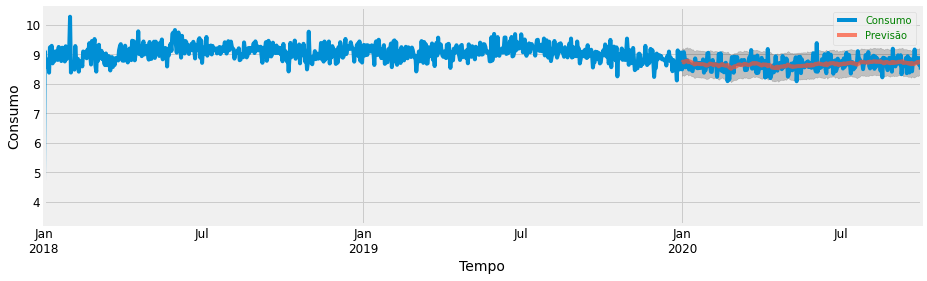

In [ ]:
#decomponto a serie em trend, seasonality e noise
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(jerimum.values, model='additive', freq=30)
 
mod = sm.tsa.statespace.SARIMAX(jerimum,
                                order=(1, 1, 1),
                                seasonal_order=(0, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

# results.plot_diagnostics(figsize=(18, 8))
# plt.show()
# previsao_tempo = ano_previsao + '-01'
# pred = results.get_prediction(start=pd.to_datetime(previsao_tempo), dynamic=False)
# pred_ci = pred.conf_int(alpha=0.001)
# ax = jerimum[ano_comeco:].plot(label='observed')
# pred.predicted_mean.plot(ax=ax, label='Previsão', alpha=.7, figsize=(14, 4))
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)
# ax.set_xlabel('Tempo')
# ax.set_ylabel('Consumo')
# plt.legend()
# plt.show()

In [ ]:
pred_uc = results.get_forecast(steps=30)
pred_ci = pred_uc.conf_int(alpha=0.0000001)
pred_ci = pred_ci.rename(columns={'lower Consumo': 'Limite Inferior', 'upper Consumo': 'Limite Superior'})

pred_ci


,Limite Inferior,Limite Superior
2020-10-01,7.397283,10.058109
2020-10-02,7.401397,10.063279
2020-10-03,7.379386,10.049161
2020-10-04,7.373197,10.050346
2020-10-05,7.350895,10.035423
2020-10-06,7.370587,10.062472
2020-10-07,7.364380,10.063603
2020-10-08,7.355618,10.062159
2020-10-09,7.356124,10.069962
2020-10-10,7.360046,10.081163
